# Info

This notebook represents EDA ( Exploratory Data Analysis). Generally this notebook was used, to familiarize myself with the data

# Imports

In [2]:
# all of the required imports, data setup, any extra code
import psutil
import h5py
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from sklearn.metrics import mutual_info_score

try:
  import google.colab
  COLAB_ENV = True
except:
  COLAB_ENV = False

if COLAB_ENV:
  start = "/" + os.path.join("content","drive","MyDrive","datasets")
  from google.colab import drive
  drive.mount('/content/drive')
else:
  start = "data"

# Loading and Inspecting the data
use the below to download the data
```shell
./download_data.sh
```

The files are stored as .hdf5 files ( [Hierarchical Data Format](https://en.wikipedia.org/wiki/Hierarchical_Data_Format)). Print some initial statistics of the files

In [5]:
def printH5PYFile(file : h5py.File) -> None:
    keys = file.keys()
    print(f"for {file}")
    print("found keys : ", keys)
    for k in keys:
        print(f"Shape of key {k} is {file[k].shape}")

# setup paths
data_filepath = os.path.join(start, "CERN", "ParticleClassification")
photon_file = "SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5"
electron_file = "SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5"
photon_filepath = os.path.join(data_filepath, photon_file)
electron_filepath = os.path.join(data_filepath, electron_file)

# actaully load the data
electronFile = h5py.File(electron_filepath, "r")
photonFile = h5py.File(photon_filepath, "r")

# print the format of the data
print ("Data Format\n")
printH5PYFile(electronFile)
print("")
printH5PYFile(photonFile)
print("")

Data Format

for <HDF5 file "SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5" (mode r)>
found keys :  <KeysViewHDF5 ['X', 'y']>
Shape of key X is (249000, 32, 32, 2)
Shape of key y is (249000,)

for <HDF5 file "SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5" (mode r)>
found keys :  <KeysViewHDF5 ['X', 'y']>
Shape of key X is (249000, 32, 32, 2)
Shape of key y is (249000,)



In [6]:
# load the data ( from X and y keys ), for electron and photon
# the dataset is fairly large, print the size of it ( I needed to watch out for RAM restrictions on my laptop)
ElectronX, ElectronY = electronFile["X"], electronFile["y"]
PhotonX, PhotonY = photonFile["X"], photonFile["y"]
totalBytes = ElectronX.nbytes + ElectronY.nbytes + PhotonX.nbytes + PhotonY.nbytes
print(f"Total size of the whole dataset in bytes is {totalBytes } B , {round(totalBytes / (1024 * 1024 * 1024),2)} GB")

Total size of the whole dataset in bytes is 4081608000 B , 3.8 GB


The energies of Electron


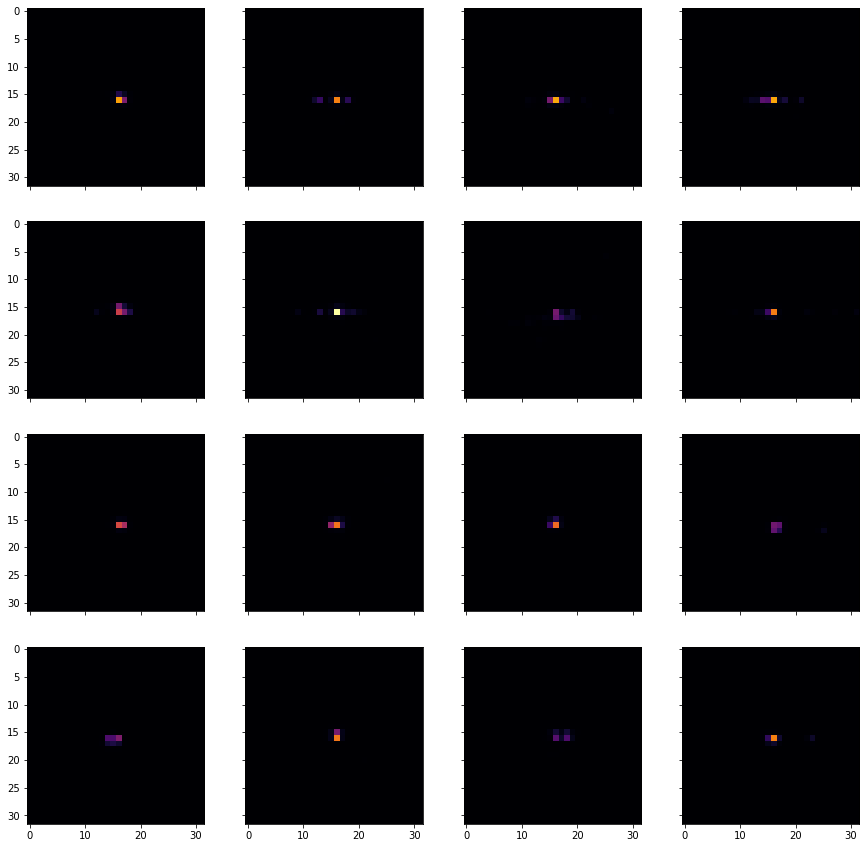

In [18]:
# helper function that takes a subset of images and pl a square
def plotSquareMatrix(dataset, nImagesToPlot, channel, _title):
    nImages = dataset.shape[0]
    indexes = sorted(np.random.permutation(nImages)[:nImagesToPlot*nImagesToPlot])

    print(_title)
    fig, axs = plt.subplots(nImagesToPlot, nImagesToPlot, figsize=(15,15), sharex=True, sharey=True)
    i = 0
    maxima = np.max(dataset[indexes, :, :, channel])
    minima = np.min(dataset[indexes, :, :, channel])

    for y in range(nImagesToPlot):
        for x in range(nImagesToPlot):
            idx = indexes[i]
            axs[y, x].imshow(dataset[idx, :, :, channel], cmap="inferno", vmin=minima, vmax=maxima)
            i += 1
    return fig

plotSquareMatrix(ElectronX, 4, 0,"The energies of Electron")
plt.show()

The energies of Photon


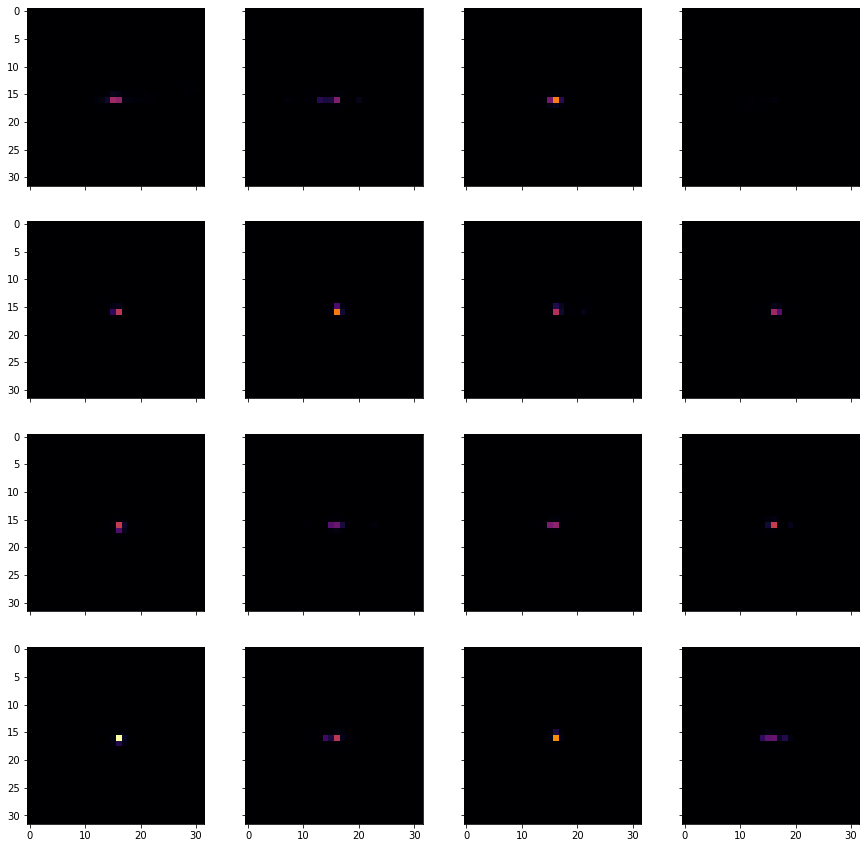

In [21]:
plotSquareMatrix(PhotonX, 4, 0, "The energies of Photon")
plt.show()

The timeHits of Electron


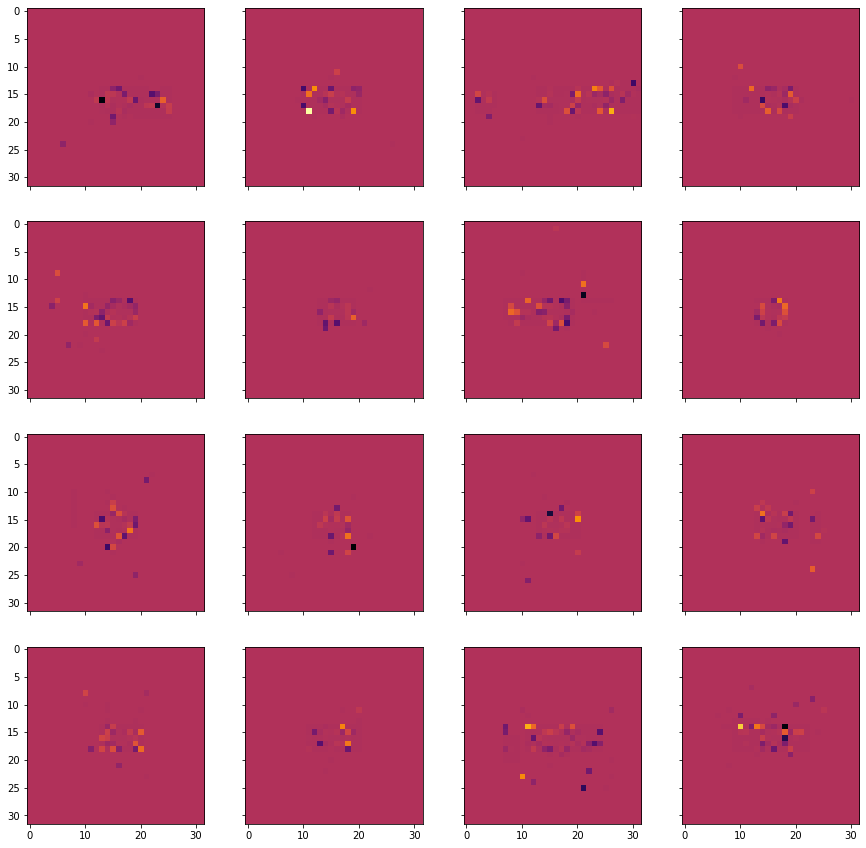

In [22]:
plotSquareMatrix(ElectronX, 4, 1,"The timeHits of Electron")
plt.show()

The timeHits of Photon


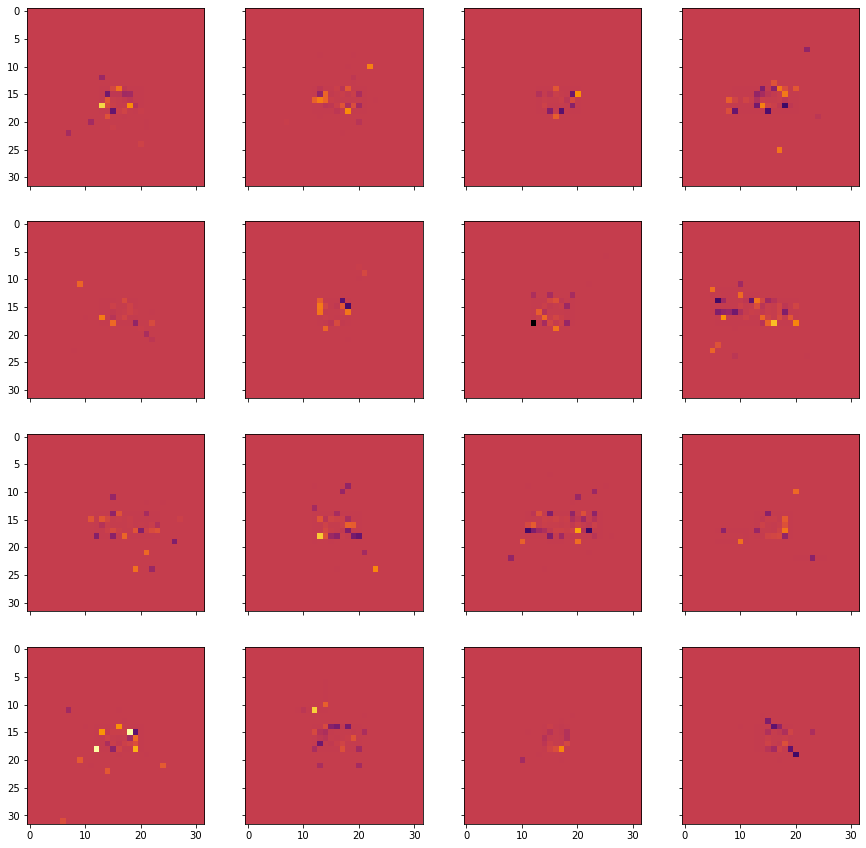

In [23]:
plotSquareMatrix(PhotonX, 4, 1,"The timeHits of Photon")
plt.show()

From the above plots the distinction between the photon and electron is not very clear. It seeme that the data is extremely sparse.

In [24]:
# concatenate the dataset, to calculate the statistics of whole dataset
whole_dataset_X = np.concatenate([ElectronX, PhotonX])
whole_dataset_Y = np.concatenate([ElectronY, PhotonY])

In [25]:
mu = [np.mean(whole_dataset_X[:, :, :, 0]), np.mean(whole_dataset_X[:, :, :, 1])]
sigma = [np.std(whole_dataset_X[:, :, :, 0]), np.std(whole_dataset_X[:, :, :, 1])]
print("mu = ", mu)
print("sigma = ", sigma)

mu =  [0.001219672, -0.0002618075]
sigma =  [0.023721104, 0.06738354]


This does confirm, that the data is extremely sparse

## Mean images
The above was means and standard deviations of the whole dataset ( and result isn't very meaningful )
Let's calculate the pixelwise means ( it seems that the pixels are distributed on the center)

In [27]:
meanPhotonX = np.mean(PhotonX, axis=0)
meanElectronX = np.mean(ElectronX, axis=0)
print(meanPhotonX.shape)
print(meanElectronX.shape)

(32, 32, 2)
(32, 32, 2)


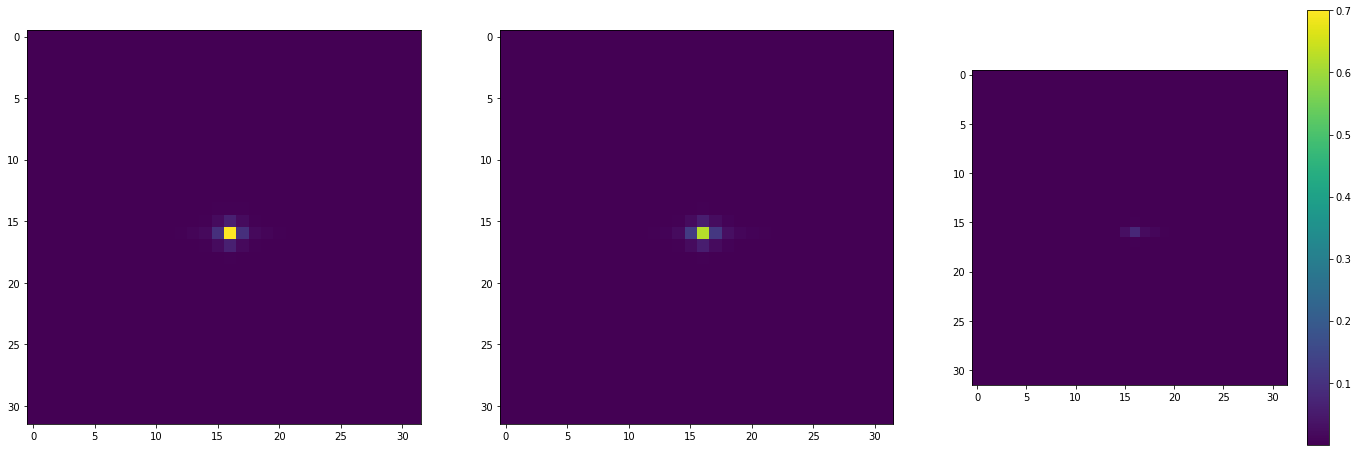

In [55]:
n = 8
plt.figure(figsize=(3*n, 1*n))

M = max(np.max(meanPhotonX[:,:,0]), np.max(meanElectronX[:,:, 0]))
m = min(np.min(meanPhotonX[:,:,0]), np.min(meanElectronX[:,:, 0]))

plt.subplot(1, 3, 1)
plt.imshow(meanPhotonX[:,:,0], vmin=m, vmax=M)

plt.subplot(1, 3, 2)
plt.imshow(meanElectronX[:, :, 0], vmin=m, vmax=M)

plt.subplot(1,3,3)
difference = np.abs(meanPhotonX[:,:,0] - meanElectronX[:,:, 0])
plt.imshow(difference, vmin=m, vmax=M)

plt.colorbar()
plt.show()

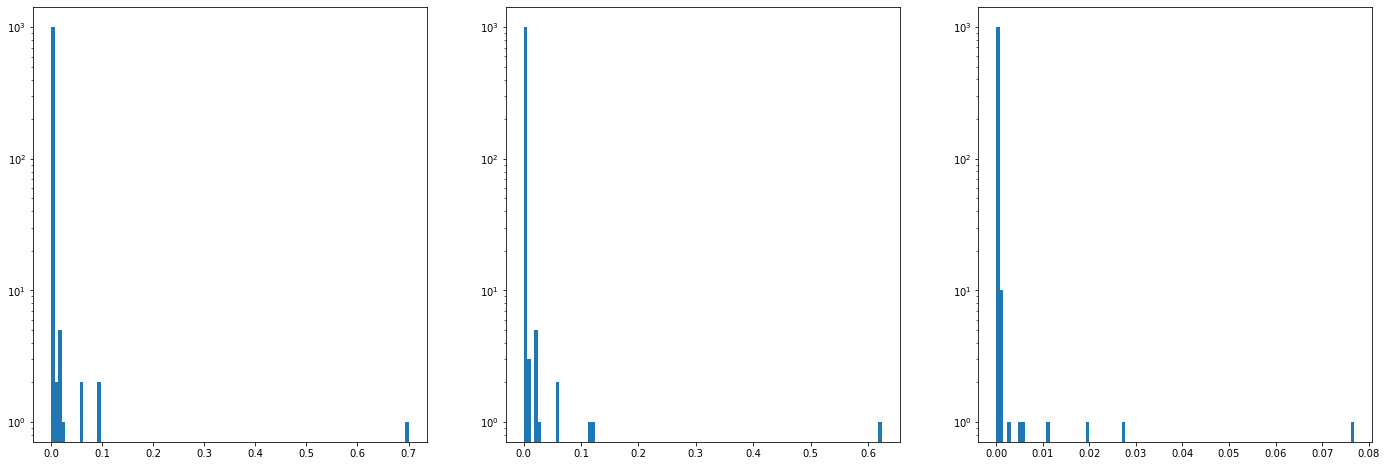

In [60]:
n = 8
plt.figure(figsize=(3*n, 1*n))

plt.subplot(1, 3, 1)
plt.hist(meanPhotonX[:,:,0].reshape(-1), bins=100, log=True)

plt.subplot(1, 3, 2)
plt.hist(meanElectronX[:, :, 0].reshape(-1), bins=100, log=True)

plt.subplot(1,3,3)
plt.hist(difference.reshape(-1), bins=100, log=True)
plt.show()

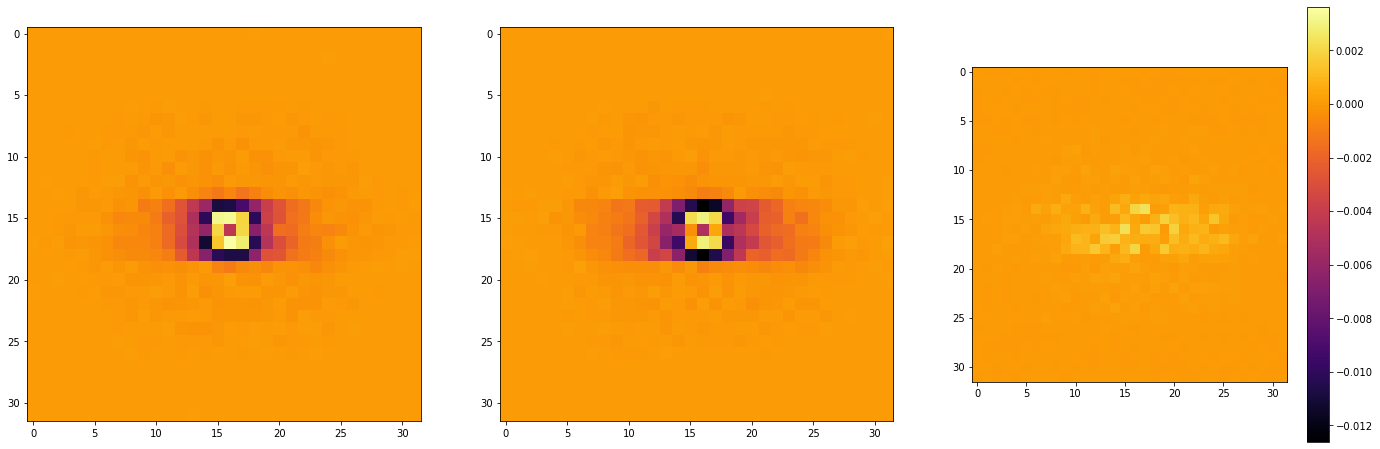

In [62]:
n = 8
plt.figure(figsize=(3*n, 1*n))

M = max(np.max(meanPhotonX[:,:,1]), np.max(meanElectronX[:,:, 1]))
m = min(np.min(meanPhotonX[:,:,1]), np.min(meanElectronX[:,:, 1]))

plt.subplot(1, 3, 1)
plt.imshow(meanPhotonX[:,:,1], vmin=m, vmax=M, cmap="inferno")

plt.subplot(1, 3, 2)
plt.imshow(meanElectronX[:, :, 1], vmin=m, vmax=M, cmap="inferno")

plt.subplot(1,3,3)
difference = np.abs(meanPhotonX[:,:,1] - meanElectronX[:,:, 1])
plt.imshow(difference, vmin=m, vmax=M, cmap="inferno")

plt.colorbar()
plt.show()

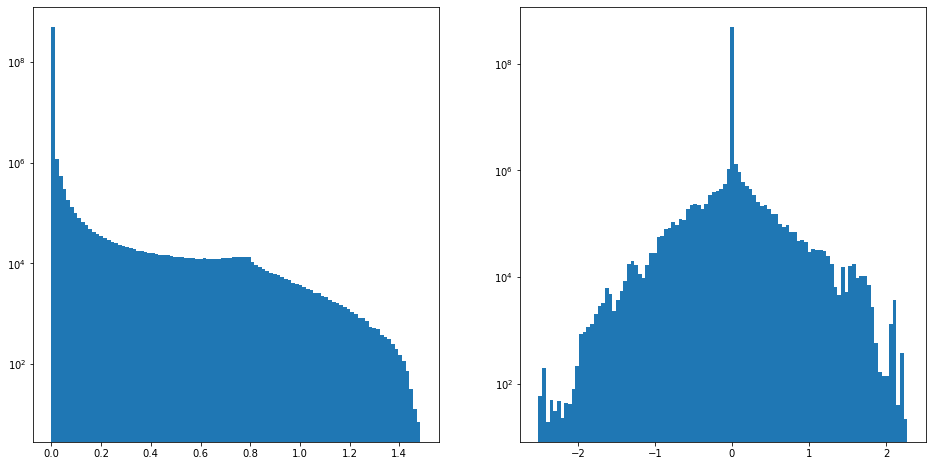

In [10]:
unraveled = whole_dataset_X.reshape(-1, 2)
plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.hist(unraveled[:, 0], bins=100, log=True)
plt.subplot(1, 2, 2)
plt.hist(unraveled[:, 1], bins=100, log=True)
plt.show()

In [11]:
print("Energy ")
hist = np.histogram(unraveled[:, 0], bins=10)
for (x,y) in zip(hist[0], hist[1]):
    print(f"{x} : {y}")

Energy 
509018322 : 0.0
321725 : 0.1484944373369217
174262 : 0.2969888746738434
133580 : 0.4454832971096039
126181 : 0.5939777493476868
103506 : 0.7424721717834473
45013 : 0.8909665942192078
20341 : 1.0394610166549683
7568 : 1.1879554986953735
1502 : 1.3364498615264893


In [12]:
print("Time ")
hist = np.histogram(unraveled[:, 1], bins=10)
for (x,y) in zip(hist[0], hist[1]):
    print(f"{x} : {y}")

Time 
595 : -2.512557029724121
23433 : -2.0335042476654053
111955 : -1.5544517040252686
776053 : -1.0753989219665527
2893444 : -0.5963462591171265
504350801 : -0.1172935962677002
1341413 : 0.36175909638404846
342336 : 0.8408117890357971
102767 : 1.3198645114898682
9203 : 1.7989171743392944


In [13]:
HitEnergyElectron = ElectronX[:, :, :, 0]
HitEnergyPhoton = ElectronX[:, :, :, 0]

eps = 1e-4

I2HitEnergyElectron = np.sqrt(np.sum(HitEnergyElectron.reshape(-1, 32 * 32)**2, axis=1)) + eps
HitEnergyElectron = np.abs(HitEnergyElectron) / I2HitEnergyElectron.reshape(-1,1,1)

I2HitEnergyPhoton = np.sqrt(np.sum(HitEnergyElectron.reshape(-1, 32 * 32)**2, axis=1)) + eps
HitEnergyPhoton = np.abs(HitEnergyPhoton) / I2HitEnergyPhoton.reshape(-1,1,1)

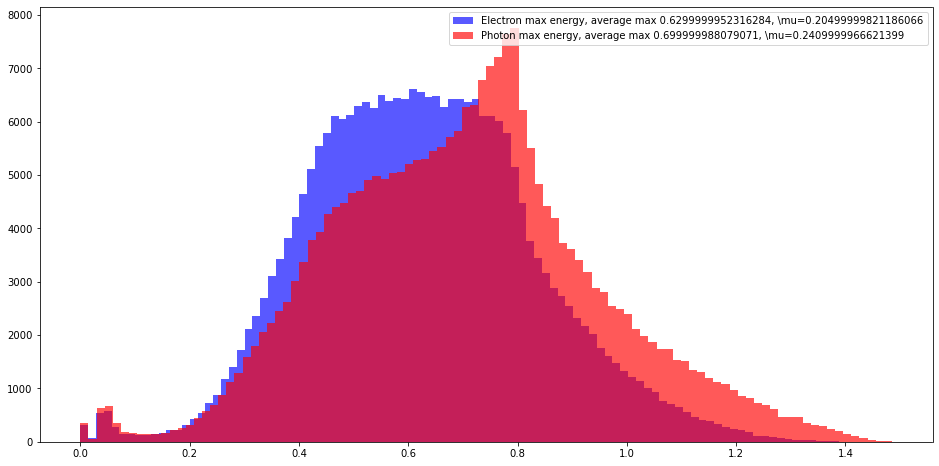

In [31]:
plt.figure(figsize=(16,8))
ElectronAverageMaxEnergy = np.mean(np.max(ElectronX[:, :, :, 0].reshape(-1, 32 * 32), axis=1))
roundedElectronAverageMaxEnergy = round(ElectronAverageMaxEnergy, 2)
roundedElectronStdMaxEnergy = round(np.std(np.max(ElectronX[:, :, :, 0].reshape(-1, 32 * 32), axis=1)), 3)

plt.hist(np.max(ElectronX[:, :, :, 0].reshape(-1, 32 * 32), axis=1), bins=100, color="blue", alpha=0.65, label=f"Electron max energy, average max {roundedElectronAverageMaxEnergy}, \mu={roundedElectronStdMaxEnergy}")
ElectronAverageMaxEnergy = np.mean(np.max(PhotonX[:, :, :, 0].reshape(-1, 32 * 32), axis=1))
roundedPhotonAverageMaxEnergy = round(ElectronAverageMaxEnergy, 2)
roundedPhotonStdMaxEnergy = round(np.std(np.max(PhotonX[:, :, :, 0].reshape(-1, 32 * 32), axis=1)), 3)
plt.hist(np.max(PhotonX[:, :, :, 0].reshape(-1, 32 * 32), axis=1), bins=100, color="red", alpha=0.65, label=f"Photon max energy, average max {roundedPhotonAverageMaxEnergy}, \mu={roundedPhotonStdMaxEnergy}")
plt.legend()
plt.show()

(32, 32)
(32, 32)


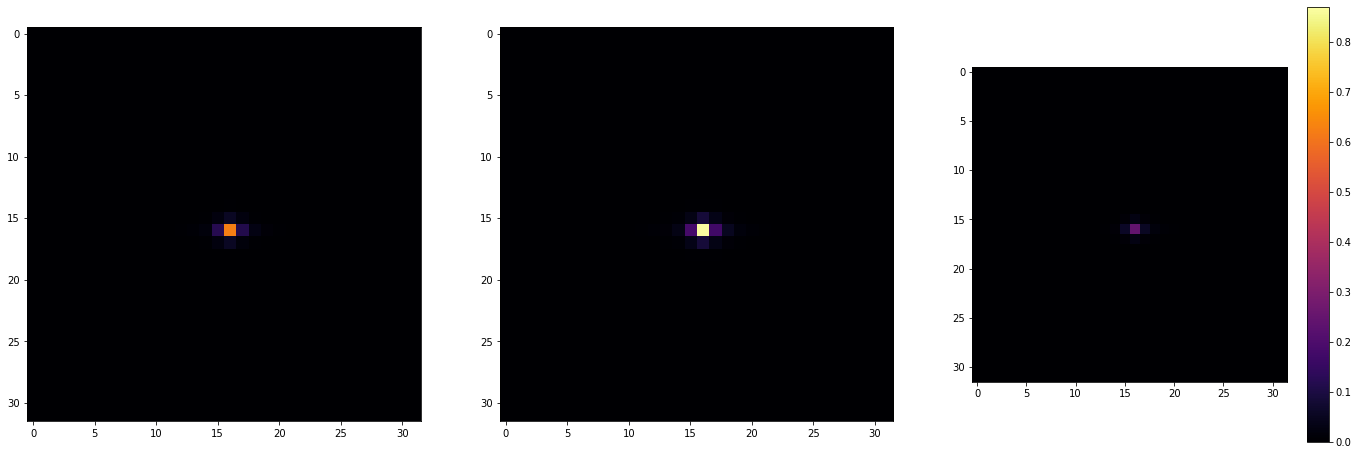

In [52]:
meanPhotonXScaled = np.mean(HitEnergyPhoton, axis=0)
meanElectronXScaled = np.mean(HitEnergyElectron, axis=0)
print(meanPhotonXScaled.shape)
print(meanElectronXScaled.shape)

plt.figure(figsize=(24,8))
plt.subplot(1, 3, 1)
plt.imshow(meanPhotonXScaled, vmin=0, vmax=0.87, cmap="inferno")

plt.subplot(1, 3, 2)
plt.imshow(meanElectronXScaled, vmin=0, vmax=0.87, cmap="inferno")

plt.subplot(1, 3, 3)
plt.imshow(np.abs(meanPhotonXScaled - meanElectronXScaled), vmin=0, vmax=0.87, cmap="inferno")
plt.colorbar()

[]

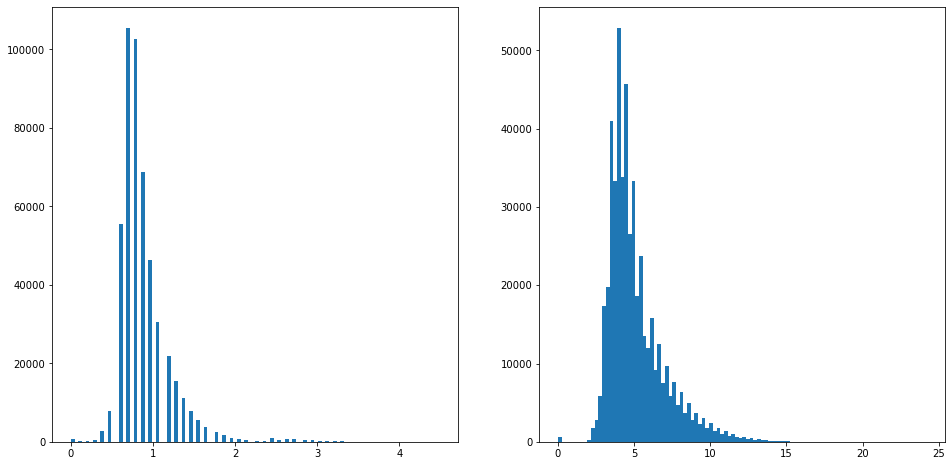

In [14]:
plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.hist(100*np.sum(np.abs(whole_dataset_X[:,:,:,0].reshape(-1, 32*32)) >= 1e-2, axis=1) / 1024, bins=100)

plt.subplot(1, 2, 2)
plt.hist(100*np.sum(np.abs(whole_dataset_X[:,:,:,1].reshape(-1, 32*32)) >= 1e-2, axis=1) / 1024, bins=100)

plt.plot()

In [16]:

electronEnergyXDistribution = np.histogram(np.max(ElectronX[:, :, :, 0].reshape(-1, 32 * 32), axis=1), bins=100)
photonEnergyXDistribution = np.histogram(np.max(PhotonX[:, :, :, 0].reshape(-1, 32 * 32), axis=1), bins=100)

In [17]:
print(f"JS : {distance.jensenshannon(electronEnergyXDistribution[0], photonEnergyXDistribution[0])}")
print(f"KL : {mutual_info_score(electronEnergyXDistribution[0], photonEnergyXDistribution[0])}")

JS : 0.10297025045614622
KL : 4.549718411543298


In [14]:
electronEnergyXDistribution

(array([ 313,   75,  537,  574,  283,  155,  148,  128,  128,  146,  170,
         218,  228,  318,  420,  545,  718,  874, 1172, 1396, 1719, 2106,
        2362, 2700, 3109, 3432, 3814, 4208, 4647, 5112, 5550, 5787, 6107,
        6055, 6132, 6284, 6365, 6263, 6494, 6393, 6437, 6415, 6615, 6549,
        6453, 6477, 6265, 6417, 6427, 6361, 6427, 6105, 6109, 6003, 5793,
        5149, 4484, 3769, 3443, 3170, 2890, 2723, 2541, 2318, 2179, 2022,
        1762, 1616, 1479, 1318, 1220, 1143, 1015,  928,  769,  713,  661,
         567,  474,  416,  381,  327,  279,  242,  224,  176,  104,  109,
          85,   77,   51,   32,   25,   27,   19,   14,   10,    4,    4,
           3]),
 array([0.        , 0.01431813, 0.02863626, 0.04295439, 0.05727252,
        0.07159065, 0.08590878, 0.10022691, 0.11454504, 0.12886317,
        0.1431813 , 0.15749943, 0.17181756, 0.1861357 , 0.20045382,
        0.21477196, 0.22909008, 0.2434082 , 0.25772634, 0.27204448,
        0.2863626 , 0.30068073, 0.31499887, 0.